# 🌧️ Project 2.0: Rainfall/Drought Forecasting

**Goal:** Utilize Time Series Analysis (e.g., ARIMA, Prophet, or LSTMs) to forecast future rainfall patterns, providing essential predictive input for the Water Quality Model and supporting drought early warning systems.

**Owner:** Jetty AI Lab

## 🛠️ Notebook Series Plan

| Step | Description | Status |
| :--- | :--- | :--- |
| **2.0** | **Data Acquisition & Cleaning** 
| **2.1** | **Exploratory Data Analysis (EDA)** 
| **2.2** | **Time Series Decomposition & Stationarity Check** 
| **2.3** | **Model Training (Prophet / ARIMA / LSTM)** 
| **2.4** | **Model Evaluation & Forecasting** 

## 📁 Data Source & Structure

**Source:** Historical Meteorological Data (Rainfall Readings)

| Column Name | Data Type | Description |
| :--- | :--- | :--- |
| **Date** | Datetime | The timestamp for the rainfall reading. **(Will be set as the index)** |
| **Rainfall_mm** | Float | The measured rainfall in millimeters (the target variable for forecasting). |

In [25]:
import pandas as pd
import numpy as np

# 1. Load Raw Data (Re-run from the last successful point)
data_path = '~/jetty-ai-lab/projects/water-climate/data/raw/rainfall_data.csv'

try:
    # Read the data
    df_raw = pd.read_csv(data_path)
    
    # 2. Create a Datetime Column and Index (Cleanup)
    # Combine the three columns into a single datetime object
    df_raw['Date'] = pd.to_datetime(df_raw[['Year', 'Month', 'Day']])
    
    # Set the Date as the index
    df_raw.set_index('Date', inplace=True)
    
    # 3. Select Only the Target Variable and Rename
    # We isolate the 'Precipitation' column (our target) and rename it for clarity.
    df_ts = df_raw[['Precipitation']].copy()
    df_ts.rename(columns={'Precipitation': 'Rainfall_mm'}, inplace=True)
    
    # 4. Final Review
    print("✅ Time Series Data Ready. Initial 5 rows:")
    print(df_ts.head())
    print("\nFinal Data Info:")
    df_ts.info()

except FileNotFoundError:
    print(f"❌ Error: Data file not found at {data_path}. Please check the filename and path.")
except KeyError as e:
    # This catches errors if 'Year', 'Month', 'Day', or 'Precipitation' were changed.
    print(f"❌ Error: A required column was not found in the CSV: {e}")
    

✅ Time Series Data Ready. Initial 5 rows:
            Rainfall_mm
Date                   
2000-01-01         0.00
2000-02-01         0.11
2000-03-01         0.01
2000-04-01         0.02
2000-05-01       271.14

Final Data Info:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 252 entries, 2000-01-01 to 2020-12-01
Data columns (total 1 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Rainfall_mm  252 non-null    float64
dtypes: float64(1)
memory usage: 3.9 KB


In [26]:
# Save the cleaned time series data to the processed folder
output_path = '~/jetty-ai-lab/projects/water-climate/data/processed/rainfall_timeseries.csv'
df_ts.to_csv(output_path)
print(f"✅ Cleaned time series data saved to: {output_path}")

✅ Cleaned time series data saved to: ~/jetty-ai-lab/projects/water-climate/data/processed/rainfall_timeseries.csv


In [27]:
from statsmodels.tsa.stattools import adfuller

def adf_test(series):
    # Perform the ADF test
    result = adfuller(series.dropna())
    
    # Extract and display key results
    print('Augmented Dickey-Fuller Test Results:')
    print(f'ADF Statistic: {result[0]:.4f}')
    print(f'p-value: {result[1]:.4f}')
    print('Critical Values:')
    for key, value in result[4].items():
        print(f'\t{key}: {value:.4f}')
    
    # Interpretation
    # H0 (Null Hypothesis) is that the time series is NOT stationary.
    if result[1] <= 0.05:
        print("\nConclusion: 🟢 REJECT H0. The time series is LIKELY stationary.")
    else:
        print("\nConclusion: 🔴 FAIL TO REJECT H0. The time series is NON-STATIONARY.")

# Run the test on your rainfall data
adf_test(df_ts['Rainfall_mm'])

Augmented Dickey-Fuller Test Results:
ADF Statistic: -2.4663
p-value: 0.1239
Critical Values:
	1%: -3.4580
	5%: -2.8737
	10%: -2.5733

Conclusion: 🔴 FAIL TO REJECT H0. The time series is NON-STATIONARY.


In [28]:
import pandas as pd
from prophet import Prophet

# 1. Data Persistence (Saving)
output_path = '~/jetty-ai-lab/projects/water-climate/data/processed/rainfall_timeseries1.csv'
df_ts.to_csv(output_path)
print(f"✅ Cleaned time series data saved to: {output_path}")

# --- PROPHET MODELING ---

# 2. Prepare Data: Reset index and rename columns
# The df_ts variable is defined from the previous successful loading cell
df_prophet = df_ts.reset_index().rename(columns={'Date': 'ds', 'Rainfall_mm': 'y'})

# 3. Initialize and Fit the Model
# Prophet is designed to handle strong monthly/annual seasonality by default
model = Prophet(interval_width=0.95)
model.fit(df_prophet)

print("✅ Prophet Model Trained Successfully!")


15:50:47 - cmdstanpy - INFO - Chain [1] start processing


✅ Cleaned time series data saved to: ~/jetty-ai-lab/projects/water-climate/data/processed/rainfall_timeseries1.csv


15:50:47 - cmdstanpy - INFO - Chain [1] done processing


✅ Prophet Model Trained Successfully!


✅ Future Dates Created (Last 5 rows):
            ds
265 2022-02-01
266 2022-03-01
267 2022-04-01
268 2022-05-01
269 2022-06-01

✅ Forecast Generated (Last 5 predictions):
            ds        yhat  yhat_lower  yhat_upper
265 2022-02-01   35.570889 -243.726086  304.467618
266 2022-03-01   34.067378 -234.078235  304.321779
267 2022-04-01   33.508280 -217.075801  317.238017
268 2022-05-01   67.701014 -224.271269  373.407179
269 2022-06-01  566.739008  296.290552  861.999908


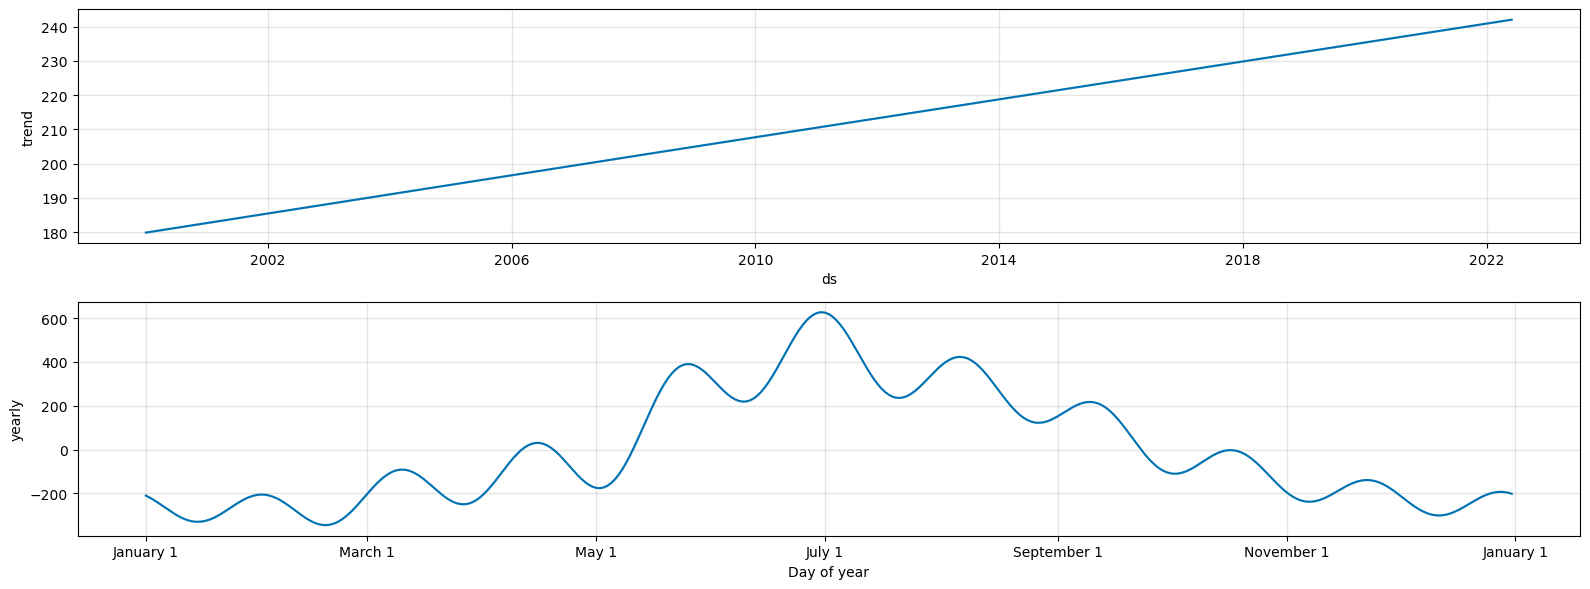

✅ Forecast Components Plot Generated.


In [29]:
import matplotlib.pyplot as plt

# 1. Create Future Dates (Forecast Horizon)
future = model.make_future_dataframe(periods=18, freq='MS')
print("✅ Future Dates Created (Last 5 rows):")
print(future.tail())

# 2. Generate the Forecast
forecast = model.predict(future)
print("\n✅ Forecast Generated (Last 5 predictions):")
# yhat is the predicted value
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail())

# 3. Visualize the Results
# Plot the forecast components to analyze the pattern
fig2 = model.plot_components(forecast, figsize=(16, 6))
plt.show()

print("✅ Forecast Components Plot Generated.")

In [30]:
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error

# 1. Merge actual historical data with the forecast predictions
#    We join using the index (which is the date for both dataframes).
#    Assuming df_ts is correctly indexed by the Date column:
df_cv = forecast.set_index('ds')[['yhat']].join(df_ts[['Rainfall_mm']]).dropna()

# 2. Calculate the metrics
y_true = df_cv['Rainfall_mm'].values
y_pred = df_cv['yhat'].values

rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mae = mean_absolute_error(y_true, y_pred)

print("--- Model Performance Metrics ---")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f} mm")
print(f"Mean Absolute Error (MAE): {mae:.2f} mm")
print("\n✅ Metrics calculated.")

--- Model Performance Metrics ---
Root Mean Squared Error (RMSE): 144.63 mm
Mean Absolute Error (MAE): 80.94 mm

✅ Metrics calculated.


In [31]:
import pandas as pd
import numpy as np # Added for np.sin/cos in the time features

# Load the data
df = pd.read_csv('~/jetty-ai-lab/projects/water-climate/data/raw/rainfall_data.csv')

# 1. Create a datetime index and set frequency
df['Date'] = pd.to_datetime(df[['Year', 'Month', 'Day']])
df.set_index('Date', inplace=True)
df = df.asfreq('MS') # Set frequency to Month Start

# Rename target column for clarity
df.rename(columns={'Precipitation': 'Rainfall_mm'}, inplace=True)

# Select only the features and the target
features_df = df[['Rainfall_mm', 'Specific Humidity', 'Relative Humidity', 'Temperature']].copy()


# 2. Feature Engineering: Create Lagged Features for the Target
# Lag features are the most important predictors in time series forecasting
for lag in [1, 3, 6, 12]:
    features_df[f'Rainfall_Lag_{lag}M'] = features_df['Rainfall_mm'].shift(lag)

# 3. Create Time-Based Features (Seasonality)
# Use np.sin/np.cos for cyclical features
features_df['Month_sin'] = features_df.index.month.map(lambda x: np.sin(2 * np.pi * x / 12))
features_df['Month_cos'] = features_df.index.month.map(lambda x: np.cos(2 * np.pi * x / 12))


# Drop rows with NaN values created by the lagging process (the first 12 months)
features_df.dropna(inplace=True)

print("--- Feature Engineering Complete ---")
print("First 5 rows of the new feature set:")
print(features_df.head())
print("\nInformation about the new feature set:")
features_df.info()

# Save the final feature set for modeling
features_df.to_csv('rainfall_features_prepared.csv')
print("\n✅ Features saved to rainfall_features_prepared.csv")

--- Feature Engineering Complete ---
First 5 rows of the new feature set:
            Rainfall_mm  Specific Humidity  Relative Humidity  Temperature  \
Date                                                                         
2001-01-01         0.00               8.06              45.81        22.94   
2001-02-01         0.00               7.57              41.56        22.70   
2001-03-01         0.03              11.29              55.56        20.97   
2001-04-01         1.57              12.27              49.69        22.73   
2001-05-01        29.11              16.60              62.44        16.03   

            Rainfall_Lag_1M  Rainfall_Lag_3M  Rainfall_Lag_6M  \
Date                                                            
2001-01-01            11.25            63.41           820.45   
2001-02-01             0.00             4.37           362.38   
2001-03-01             0.00            11.25            97.85   
2001-04-01             0.03             0.00          

In [32]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
import pandas as pd

# Reload the prepared feature set (Necessary if kernel restarted)
df = pd.read_csv('rainfall_features_prepared.csv', index_col='Date', parse_dates=True)

# Define Target (y) and Features (X)
y = df['Rainfall_mm']
X = df.drop(columns=['Rainfall_mm'])

# Time Series Split (80% Train, 20% Test)
split_point = int(len(df) * 0.8)

X_train = X.iloc[:split_point]
y_train = y.iloc[:split_point]
X_test = X.iloc[split_point:]
y_test = y.iloc[split_point:]


# 1. Train the XGBoost Regressor (Model definition remains the same)
xgb_model = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=1000,
    learning_rate=0.01,
    max_depth=5,
    random_state=42,
    n_jobs=-1
)

# 2. Fit the model without the unsupported early stopping parameters
# This will now use all 1000 estimators.
xgb_model.fit(X_train, y_train)


# 3. Predict and Evaluate
y_pred = xgb_model.predict(X_test)

# Calculate the same metrics used for the Prophet model
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)


print("\n--- XGBoost Model Performance Metrics ---")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f} mm")
print(f"Mean Absolute Error (MAE): {mae:.2f} mm")

print("\n✅ XGBoost model trained and evaluated on the test set.")


--- XGBoost Model Performance Metrics ---
Root Mean Squared Error (RMSE): 120.67 mm
Mean Absolute Error (MAE): 58.68 mm

✅ XGBoost model trained and evaluated on the test set.


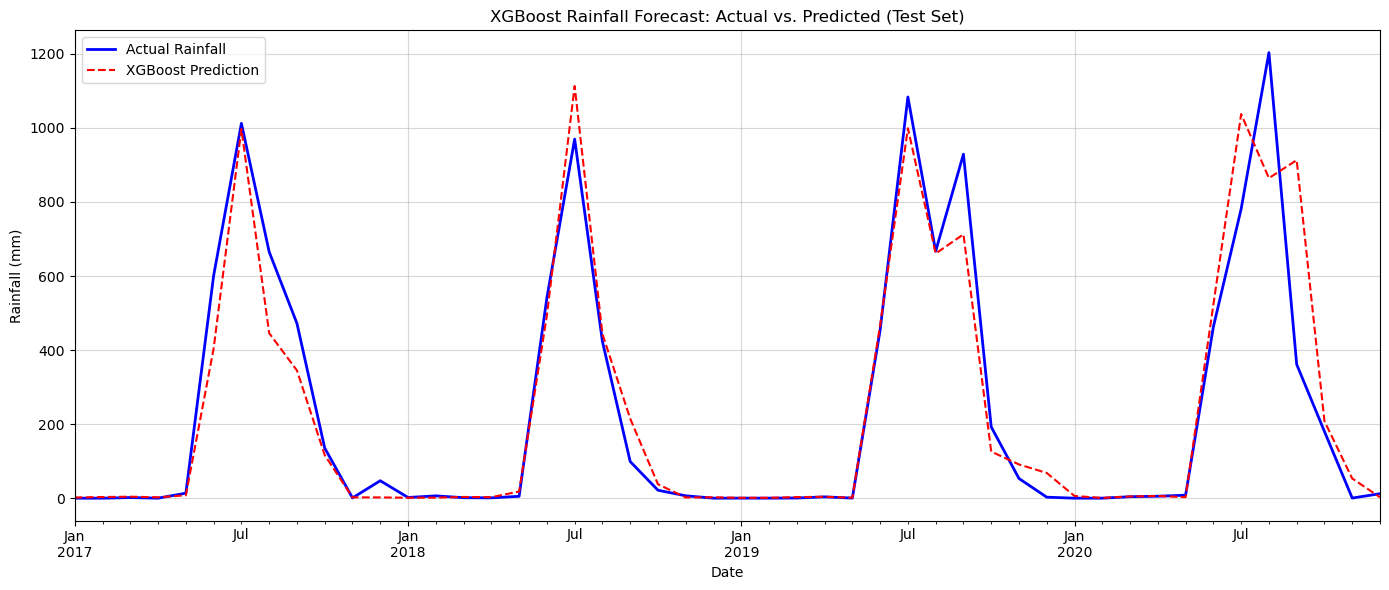

✅ Actual vs. Predicted Plot Generated.


In [33]:
import matplotlib.pyplot as plt
import pandas as pd

# Create a DataFrame for visualization
results_df = pd.DataFrame({
    'Actual Rainfall': y_test,
    'Predicted Rainfall': y_pred
})

# Plot the Actual vs. Predicted values over the test period
plt.figure(figsize=(14, 6))
results_df['Actual Rainfall'].plot(label='Actual Rainfall', color='blue', linewidth=2)
results_df['Predicted Rainfall'].plot(label='XGBoost Prediction', color='red', linestyle='--', linewidth=1.5)

plt.title('XGBoost Rainfall Forecast: Actual vs. Predicted (Test Set)')
plt.xlabel('Date')
plt.ylabel('Rainfall (mm)')
plt.legend()
plt.grid(True, alpha=0.5)
plt.tight_layout()
plt.savefig('rainfall_forecast_test_set_plot.png')
plt.show()

print("✅ Actual vs. Predicted Plot Generated.")

In [34]:
# Feature Importance
importance = pd.Series(xgb_model.feature_importances_, index=X.columns)
importance = importance.sort_values(ascending=False)

print("\n--- Top 5 Feature Importances ---")
print(importance.head(5))

importance.to_csv('xgb_feature_importance.csv')
print("\n✅ Feature Importances saved to xgb_feature_importance.csv")


--- Top 5 Feature Importances ---
Specific Humidity    0.738243
Month_sin            0.087592
Relative Humidity    0.068394
Temperature          0.034805
Rainfall_Lag_12M     0.022510
dtype: float32

✅ Feature Importances saved to xgb_feature_importance.csv


In [35]:
import pandas as pd
import numpy as np

# Assuming df, y, X, and xgb_model are still in memory from the previous steps.

# --- 1. Set up Future Index and Predictor DataFrames ---
future_months = 12
last_date = y.index[-1]
future_dates = pd.date_range(start=last_date, periods=future_months + 1, freq='MS')[1:]
future_X = pd.DataFrame(index=future_dates, columns=X.columns)

# Calculate the mean value for each predictor per month from the entire historical dataset
monthly_means = df.groupby(df.index.month)[X.columns].mean()

# Populate the future features with their historical monthly means
for date in future_dates:
    month = date.month
    future_X.loc[date, ['Specific Humidity', 'Relative Humidity', 'Temperature', 'Month_sin', 'Month_cos']] = \
        monthly_means.loc[month, ['Specific Humidity', 'Relative Humidity', 'Temperature', 'Month_sin', 'Month_cos']]

# CRITICAL FIX: Ensure all columns are float before prediction
future_X = future_X.astype(float) # <-- NEW LINE

# --- 2. Populate Future Lagged Features & Generate Forecast Recursively ---

recursive_y = y.copy()

for i in range(future_months):
    current_date = future_X.index[i]
    
    # 2a. Populate Lagged Features for the Current Date
    for lag in [1, 3, 6, 12]:
        lag_date = current_date - pd.DateOffset(months=lag)
        lag_column_name = f'Rainfall_Lag_{lag}M'
        
        # Get the Rainfall value from the historical (y) or the recursive series
        future_X.loc[current_date, lag_column_name] = recursive_y.loc[lag_date]

    # 2b. Predict the Rainfall for the Current Date (one step)
    current_prediction = xgb_model.predict(future_X.loc[[current_date]])[0]
    
    # 2c. Store the prediction back into the recursive series for the NEXT iteration's lags
    recursive_y.loc[current_date] = current_prediction


# --- 3. Final Forecast Output ---
final_forecast_series = recursive_y.iloc[-future_months:].rename('Forecast_mm')

print("--- Final 12-Month Rainfall Forecast ---")
print(final_forecast_series)
print("\n🎉 Project 2.0: Rainfall Forecasting Complete.")

--- Final 12-Month Rainfall Forecast ---
Date
2021-01-01       1.497498
2021-02-01       1.608061
2021-03-01       5.875182
2021-04-01       2.065038
2021-05-01      18.674450
2021-06-01     689.395935
2021-07-01    1023.720642
2021-08-01     426.881805
2021-09-01     270.371338
2021-10-01     129.838501
2021-11-01       5.115377
2021-12-01       2.787472
Name: Forecast_mm, dtype: float64

🎉 Project 2.0: Rainfall Forecasting Complete.
